# LLM Decision Analysis Explorer

This notebook visualizes LLM decision-making patterns on ethical dilemmas, analyzing how models weigh different values (autonomy, beneficence, nonmaleficence, justice).

In [5]:
# Setup: imports and data loading
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from src.analysis import (
    load_decisions,
    value_preference,
    value_weights,
    bootstrap_indices,
)
from src.response_models.case import VALUE_NAMES

# Configure plotting style
sns.set_theme(style="whitegrid", palette="deep")
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["font.family"] = "sans-serif"

# Load decision data
decisions = load_decisions()
print(f"Loaded {len(decisions)} decision records")

# Discover available models
models = set()
for record in decisions:
    models.update(record.models.keys())
models = sorted(models)
print(f"Models: {models}")

Loaded 51 decision records
Models: ['anthropic/claude-opus-4.5', 'deepseek/deepseek-chat', 'google/gemini-3-pro-preview', 'meta-llama/llama-4-maverick', 'mistralai/mistral-large-2512', 'moonshotai/kimi-k2-thinking', 'openai/gpt-5.2', 'perplexity/sonar-pro', 'qwen/qwen3-max', 'x-ai/grok-4']


## Value Preferences

Expected alignment E[value] for each value dimension, showing how strongly each model's choices align with each ethical value. 

- **+1**: Model consistently promotes the value
- **0**: Neutral alignment
- **-1**: Model consistently violates the value

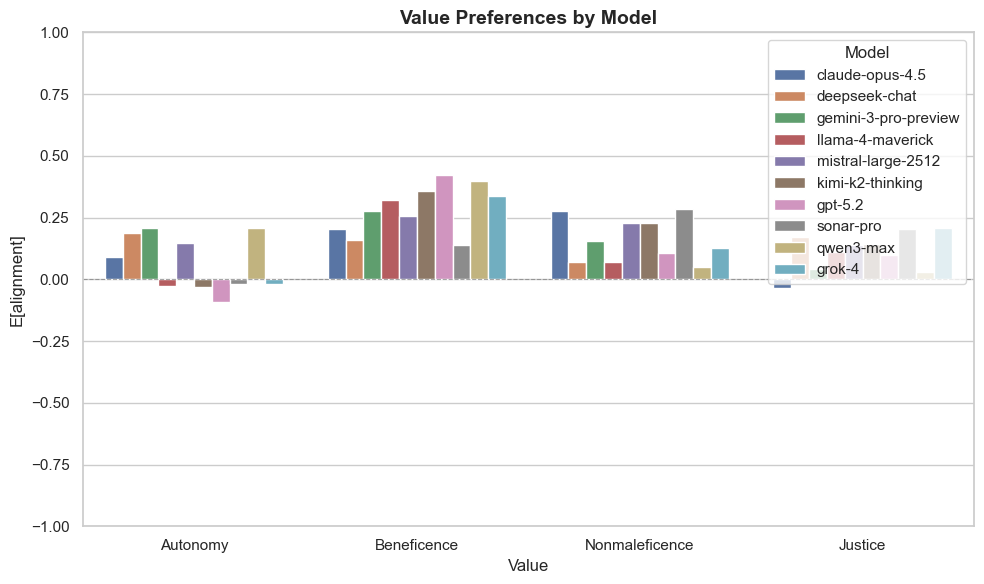

model,claude-opus-4.5,deepseek-chat,gemini-3-pro-preview,gpt-5.2,grok-4,kimi-k2-thinking,llama-4-maverick,mistral-large-2512,qwen3-max,sonar-pro
value,,,,,,,,,,
Autonomy,0.090,0.186,0.208,-0.090,-0.020,-0.031,-0.025,0.145,0.208,-0.020
Beneficence,0.202,0.161,0.275,0.422,0.335,0.357,0.322,0.257,0.398,0.139
Justice,-0.033,0.173,0.041,0.098,0.206,0.143,0.110,0.137,0.031,0.204
Nonmaleficence,0.275,0.069,0.155,0.106,0.125,0.227,0.069,0.227,0.051,0.286


In [6]:
# Compute value preferences for each (model, value) pair
preference_data = []
for model in models:
    for value in VALUE_NAMES:
        score = value_preference(decisions, model, value)
        preference_data.append({
            "model": model.split("/")[-1],  # Short name for display
            "value": value.capitalize(),
            "alignment": score
        })

pref_df = pd.DataFrame(preference_data)

# Plot grouped bar chart
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=pref_df, x="value", y="alignment", hue="model", ax=ax)
ax.axhline(y=0, color="gray", linestyle="--", linewidth=0.8, alpha=0.7)
ax.set_xlabel("Value", fontsize=12)
ax.set_ylabel("E[alignment]", fontsize=12)
ax.set_title("Value Preferences by Model", fontsize=14, fontweight="bold")
ax.set_ylim(-1, 1)
ax.legend(title="Model", loc="upper right")
plt.tight_layout()
plt.show()

# Display data table
pref_df.pivot(index="value", columns="model", values="alignment").round(3)

## Value Weights (Logistic Regression Coefficients)

Logistic regression coefficients (β) representing how much each value influences the model's choice probability. Positive coefficients indicate the model prefers choices that promote that value.

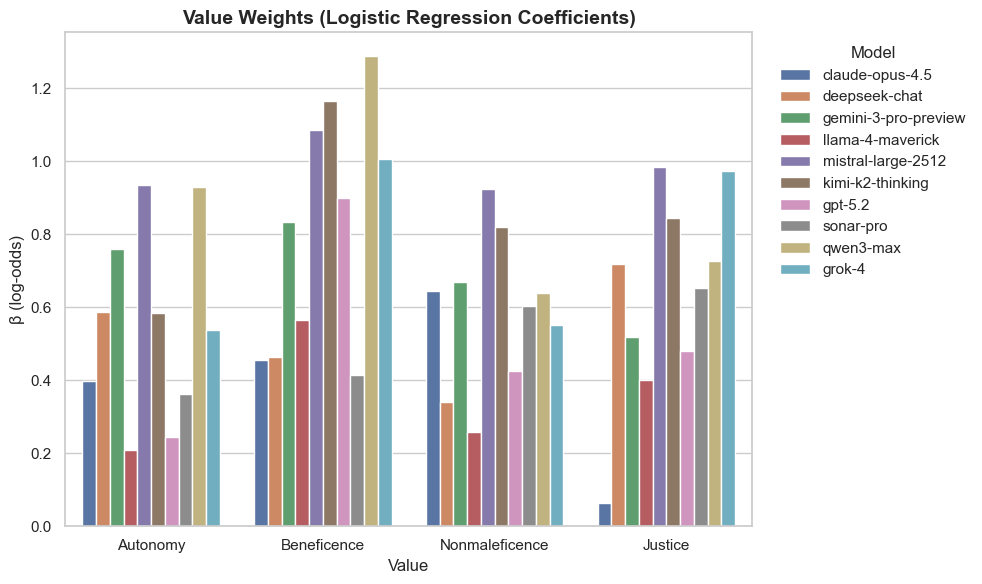

Coefficients:


model,claude-opus-4.5,deepseek-chat,gemini-3-pro-preview,gpt-5.2,grok-4,kimi-k2-thinking,llama-4-maverick,mistral-large-2512,qwen3-max,sonar-pro
value,,,,,,,,,,
Autonomy,0.399,0.588,0.760,0.243,0.538,0.583,0.209,0.936,0.931,0.363
Beneficence,0.456,0.463,0.834,0.900,1.005,1.166,0.566,1.086,1.289,0.413
Justice,0.065,0.719,0.518,0.480,0.973,0.843,0.402,0.984,0.726,0.652
Nonmaleficence,0.644,0.341,0.670,0.425,0.552,0.820,0.258,0.923,0.638,0.603



Standard Errors:


model,claude-opus-4.5,deepseek-chat,gemini-3-pro-preview,gpt-5.2,grok-4,kimi-k2-thinking,llama-4-maverick,mistral-large-2512,qwen3-max,sonar-pro
value,,,,,,,,,,
Autonomy,0.057,0.055,0.069,0.066,0.062,0.064,0.054,0.099,0.083,0.065
Beneficence,0.067,0.070,0.071,0.083,0.083,0.083,0.058,0.114,0.092,0.089
Justice,0.059,0.074,0.084,0.066,0.073,0.083,0.066,0.107,0.095,0.087
Nonmaleficence,0.061,0.054,0.068,0.073,0.057,0.059,0.051,0.075,0.062,0.078


In [7]:
# Compute value weights for each model
weights_data = []
for model in models:
    result = value_weights(decisions, model)
    for value, coef in result.coefficients.items():
        std_err = result.std_errors.get(value) if result.std_errors else None
        weights_data.append({
            "model": model.split("/")[-1],
            "value": value.capitalize(),
            "coefficient": coef,
            "std_error": std_err
        })

weights_df = pd.DataFrame(weights_data)

# Plot grouped bar chart with error bars
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=weights_df, x="value", y="coefficient", hue="model", ax=ax)
ax.axhline(y=0, color="gray", linestyle="--", linewidth=0.8, alpha=0.7)
ax.set_xlabel("Value", fontsize=12)
ax.set_ylabel("β (log-odds)", fontsize=12)
ax.set_title("Value Weights (Logistic Regression Coefficients)", fontsize=14, fontweight="bold")
ax.legend(title="Model", loc="upper left", bbox_to_anchor=(1.02, 1.0), frameon=False)
plt.tight_layout()
plt.show()

# Display coefficients table with standard errors
pivot_coef = weights_df.pivot(index="value", columns="model", values="coefficient").round(3)
pivot_se = weights_df.pivot(index="value", columns="model", values="std_error").round(3)
print("Coefficients:")
display(pivot_coef)
print("\nStandard Errors:")
display(pivot_se)

## Model Comparison

Direct comparison between models across all value dimensions. When multiple models are available, this shows pairwise differences in value preferences.

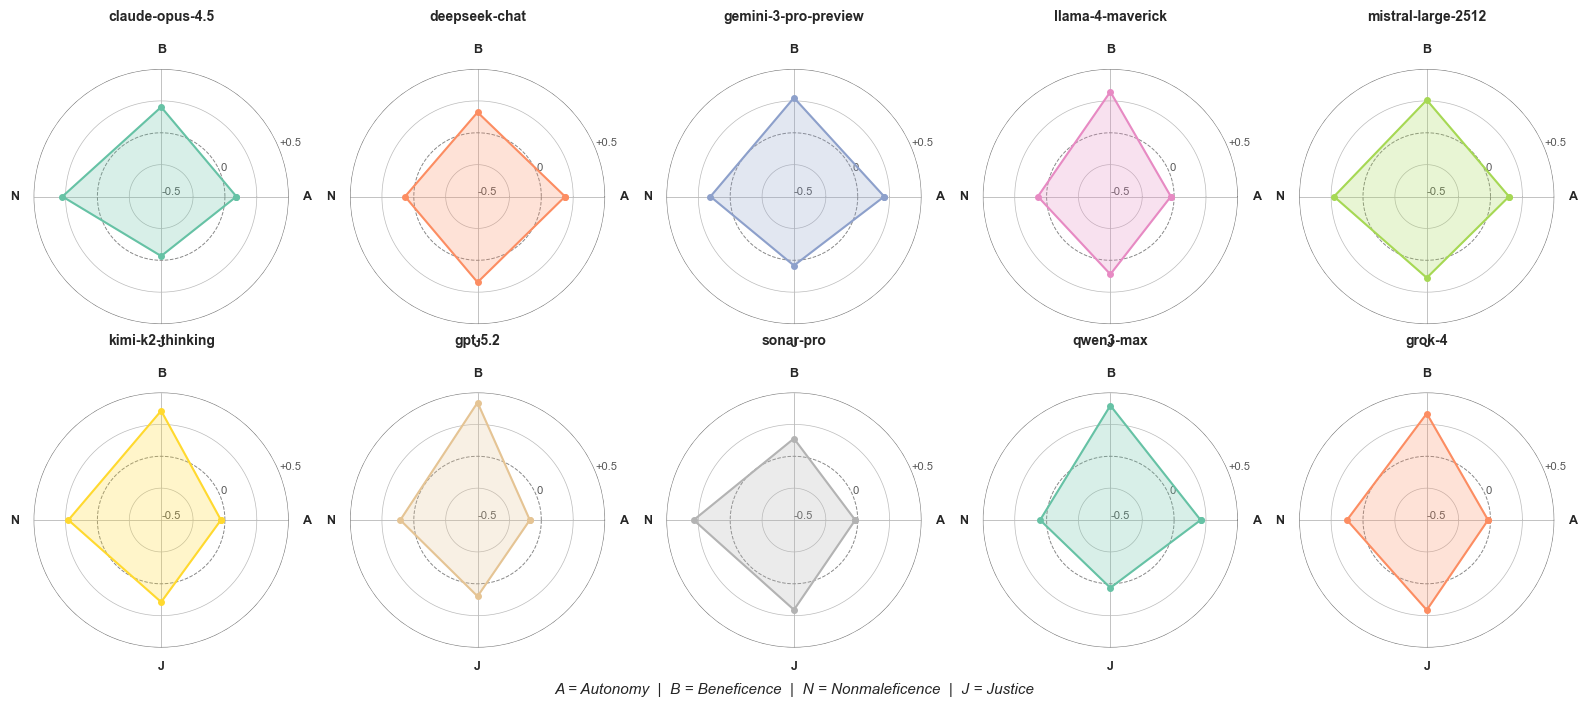

Figure: E[alignment] per value. Positive values indicate choices that promote
the value; negative values indicate choices that violate it. Dashed line = neutral.

--- Pairwise Model Differences ---

claude-opus-4.5 vs deepseek-chat:
  Autonomy       : -0.096
  Beneficence    : +0.041
  Nonmaleficence : +0.206
  Justice        : -0.206

claude-opus-4.5 vs gemini-3-pro-preview:
  Autonomy       : -0.118
  Beneficence    : -0.073
  Nonmaleficence : +0.120
  Justice        : -0.075

claude-opus-4.5 vs llama-4-maverick:
  Autonomy       : +0.116
  Beneficence    : -0.120
  Nonmaleficence : +0.206
  Justice        : -0.143

claude-opus-4.5 vs mistral-large-2512:
  Autonomy       : -0.055
  Beneficence    : -0.055
  Nonmaleficence : +0.047
  Justice        : -0.171

claude-opus-4.5 vs kimi-k2-thinking:
  Autonomy       : +0.122
  Beneficence    : -0.155
  Nonmaleficence : +0.047
  Justice        : -0.176

claude-opus-4.5 vs gpt-5.2:
  Autonomy       : +0.180
  Beneficence    : -0.220
  Nonmal

In [8]:
# Model comparison: individual radar charts for each model
if len(models) >= 1:
    # Axis order: Autonomy → Beneficence → Nonmaleficence → Justice (clockwise)
    values = [v.capitalize() for v in VALUE_NAMES]
    num_vars = len(values)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]
    
    # Calculate grid dimensions
    n_models = len(models)
    n_cols = 5
    n_rows = (n_models + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 3.5 * n_rows), 
                              subplot_kw=dict(polar=True))
    axes = np.atleast_2d(axes).flatten()
    
    # Pretty seaborn palette
    color_palette = sns.color_palette("Set2")
    theta_circle = np.linspace(0, 2 * np.pi, 100)
    
    for i, model in enumerate(models):
        ax = axes[i]
        color = color_palette[i % len(color_palette)]
        
        # Minimal radial ticks: only -0.5, 0, +0.5
        ax.set_ylim(-0.5, 0.5)
        ax.set_yticks([-0.5, 0, 0.5])
        ax.set_yticklabels(['-0.5', '0', '+0.5'], fontsize=8, color='#555555')
        
        # Radial spokes only from default grid
        ax.yaxis.grid(False)
        ax.xaxis.grid(True, color='#aaaaaa', linestyle='-', linewidth=0.5)
        
        # Draw concentric circles manually
        ax.plot(theta_circle, [-0.5] * 100, color='#777777', linewidth=0.8, linestyle='-', zorder=1)
        ax.plot(theta_circle, [-0.25] * 100, color='#bbbbbb', linewidth=0.5, linestyle='-', zorder=1)
        ax.plot(theta_circle, [0] * 100, color='#888888', linewidth=0.7, linestyle='--', zorder=1)
        ax.plot(theta_circle, [0.25] * 100, color='#bbbbbb', linewidth=0.5, linestyle='-', zorder=1)
        ax.plot(theta_circle, [0.5] * 100, color='#777777', linewidth=0.8, linestyle='-', zorder=1)
        
        # Plot model data
        model_prefs = [value_preference(decisions, model, v) for v in VALUE_NAMES]
        model_prefs += model_prefs[:1]
        
        ax.plot(angles, model_prefs, 
                marker='o', markersize=4,
                linewidth=1.5, color=color, zorder=3)
        ax.fill(angles, model_prefs, alpha=0.25, color=color, zorder=2)
        
        # Axis labels
        ax.set_thetagrids(np.degrees(angles[:-1]), [''] * num_vars)
        
        # Shorter labels for compact display - position varies by angle to avoid title overlap
        short_labels = ['A', 'B', 'N', 'J']  # Autonomy, Beneficence, Nonmaleficence, Justice
        label_radii = [0.65, 0.65, 0.65, 0.65]  # All at same radius
        for angle, label, r in zip(angles[:-1], short_labels, label_radii):
            ax.text(angle, r, label, fontsize=9, ha='center', va='center', fontweight='bold')
        
        ax.set_rlim(-0.5, 0.5)
        ax.spines['polar'].set_visible(False)
        
        # Model name as title
        ax.set_title(model.split("/")[-1], fontsize=10, fontweight='bold', pad=35)
    
    # Hide unused subplots
    for j in range(n_models, len(axes)):
        axes[j].set_visible(False)
    
    # Add legend for axis labels
    fig.text(0.5, 0.02, "A = Autonomy  |  B = Beneficence  |  N = Nonmaleficence  |  J = Justice", 
             ha='center', fontsize=11, style='italic')
    
    plt.tight_layout(rect=[0, 0.05, 1, 1])
    plt.show()
    
    # Caption for interpretation
    print("Figure: E[alignment] per value. Positive values indicate choices that promote")
    print("the value; negative values indicate choices that violate it. Dashed line = neutral.")

# Pairwise model comparison (when 2+ models available)
if len(models) >= 2:
    print("\n--- Pairwise Model Differences ---")
    for i, m1 in enumerate(models):
        for m2 in models[i+1:]:
            print(f"\n{m1.split('/')[-1]} vs {m2.split('/')[-1]}:")
            for value in VALUE_NAMES:
                p1 = value_preference(decisions, m1, value)
                p2 = value_preference(decisions, m2, value)
                diff = p1 - p2
                print(f"  {value.capitalize():15s}: {diff:+.3f}")
else:
    print("Add more models to see pairwise comparisons.")